# Cleaning & EDA — MarketPulse
**Purpose:** interactive inspection of raw data to determine cleaning rules for ETL.
- Load 2–3 tickers (sample)
- Normalize headers, preview
- Compute **log returns**
- Check missing / duplicate dates, trading ranges
- Fat-tails analysis: skew/kurtosis, Jarque-Bera, QQ-plot
- ACF of squared log returns (volatility clustering)
- Inspect yfinance `actions` (splits/dividends)
**Decisions to record:** handle splits now or flag, choose Student-t vs Normal for GARCH, any glaring data glitches.

# Project Path Setup
This cell handles the fundamental project structure setup that every notebook needs.

### What it does:
Finds project root directory by traversing up from current location until it finds a folder containing src/
Sets up data directory path pointing to project_root/data/raw where CSV files are stored
Configures Python import path so we can import custom modules from the src/ directory
Validates paths exist and prints confirmation

### Why this matters:
Without proper path setup, the notebook can't find your data files or import your custom utilities. This cell ensures everything points to the right locations regardless of where the notebook is run from.

In [1]:
from pathlib import Path
import sys

current = Path.cwd()
project_root = current
while not (project_root / "src").exists() and project_root != project_root.parent:
    project_root = project_root.parent

RAW_DIR = project_root / "data" / "raw"
sys.path.insert(0, str(project_root))

print(f"Project root: {project_root}")
print(f"RAW_DIR: {RAW_DIR}")
print(f"RAW_DIR exists: {RAW_DIR.exists()}")

Project root: e:\Projects\Market_Pulse_Daily_Volatility_And_Returns_Dashboard
RAW_DIR: e:\Projects\Market_Pulse_Daily_Volatility_And_Returns_Dashboard\data\raw
RAW_DIR exists: True


## Setup: imports, logger & data path
Load libraries, configure logger, and set RAW_DIR (from config or fallback).

In [2]:
import warnings
warnings.filterwarnings("ignore")

import logging
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid")

from scipy.stats import skew, kurtosis
from statsmodels.stats.stattools import jarque_bera
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf

from src.utils.logger import setup_logger
logger = setup_logger(__name__, level=logging.INFO)

print("Using RAW_DIR:", RAW_DIR)
logger.info("Notebook environment ready.")

[INFO] Notebook environment ready.


Using RAW_DIR: e:\Projects\Market_Pulse_Daily_Volatility_And_Returns_Dashboard\data\raw


## List raw CSVs and pick sample tickers
Show available CSVs in RAW_DIR and choose up to 3 files for exploratory work.

In [3]:
csvs = sorted(Path(RAW_DIR).glob("*.csv"))

logger.info(f'Found {len(csvs)} CSV files in RAW_DIR: {RAW_DIR}')

if not csvs:
    raise FileNotFoundError(f'No CSV files found in RAW_DIR: {RAW_DIR}. Please check your RAW_DIR and files.')

sample_files = sample_files = [f for f in csvs if f.stem in ['aapl', 'googl', 'msft', 'tsla']]
logger.info('Sample files chosen for EDA:')
for p in sample_files:
    logger.info(f'- {p.name}')

[INFO] Found 4 CSV files in RAW_DIR: e:\Projects\Market_Pulse_Daily_Volatility_And_Returns_Dashboard\data\raw
[INFO] Sample files chosen for EDA:
[INFO] - aapl.csv
[INFO] - googl.csv
[INFO] - msft.csv
[INFO] - tsla.csv


## Basic CSV Inspection

In [4]:
logger.info('Inspecting sample files:')

for i, csv_path in enumerate(sample_files):
    print(f"\n{'='*60}")
    print(f"FILE {i+1}: {csv_path.name}")
    print(f"{'='*60}")
    
    df = pd.read_csv(csv_path)
    
    print(f"Shape: {df.shape}")
    print(f"Columns: {df.columns.tolist()}")
    print(f"First few rows:")
    display(df.head(3))
    
    print(f"Data types:")
    print(df.dtypes)
    print("-" * 60)

[INFO] Inspecting sample files:



FILE 1: aapl.csv
Shape: (251, 7)
Columns: ['ticker', 'date', 'open', 'high', 'low', 'close', 'volume']
First few rows:


,ticker,date,open,high,low,close,volume
0,NaN,NaN,AAPL,AAPL,AAPL,AAPL,AAPL
1,aapl,2024-07-29,215.95008057489312,218.27918447457574,214.74570631572197,217.22412109375,36311800
2,aapl,2024-07-30,218.16970866418467,219.30440154226625,215.11399172426283,217.78152465820312,41643800


Data types:
ticker    object
date      object
open      object
high      object
low       object
close     object
volume    object
dtype: object
------------------------------------------------------------

FILE 2: googl.csv
Shape: (251, 7)
Columns: ['ticker', 'date', 'open', 'high', 'low', 'close', 'volume']
First few rows:


,ticker,date,open,high,low,close,volume
0,NaN,NaN,GOOGL,GOOGL,GOOGL,GOOGL,GOOGL
1,googl,2024-07-29,168.01611559502874,169.608393293323,167.18016866453198,168.71273803710938,20293800
2,googl,2024-07-30,169.41932361948145,170.40454137374448,167.62799790459795,169.4690704345703,18959700


Data types:
ticker    object
date      object
open      object
high      object
low       object
close     object
volume    object
dtype: object
------------------------------------------------------------

FILE 3: msft.csv
Shape: (251, 7)
Columns: ['ticker', 'date', 'open', 'high', 'low', 'close', 'volume']
First few rows:


,ticker,date,open,high,low,close,volume
0,NaN,NaN,MSFT,MSFT,MSFT,MSFT,MSFT
1,msft,2024-07-29,428.29625878283395,428.86192913835873,421.4686315229256,423.4831848144531,15125800
2,msft,2024-07-30,424.4656455012434,425.7855127211385,414.18445497765873,419.7021789550781,32687600


Data types:
ticker    object
date      object
open      object
high      object
low       object
close     object
volume    object
dtype: object
------------------------------------------------------------

FILE 4: tsla.csv
Shape: (251, 7)
Columns: ['ticker', 'date', 'open', 'high', 'low', 'close', 'volume']
First few rows:


,ticker,date,open,high,low,close,volume
0,NaN,NaN,TSLA,TSLA,TSLA,TSLA,TSLA
1,tsla,2024-07-29,224.89999389648438,234.27000427246094,224.6999969482422,232.10000610351562,129201800
2,tsla,2024-07-30,232.25,232.41000366210938,220.0,222.6199951171875,100560300


Data types:
ticker    object
date      object
open      object
high      object
low       object
close     object
volume    object
dtype: object
------------------------------------------------------------


## Comprehensive CSV Inspection

In [5]:
logger.info('Starting comprehensive inspection of sample files')

for i, csv_path in enumerate(sample_files):
    logger.info(f'Processing file: {csv_path.name}')

    print(f'\n{'='*60}')
    print(f"FILE {i+1}: {csv_path.name}")
    print(f'\n{'='*60}')

    df = pd.read_csv(csv_path)

    print(f"Shape: {df.shape}")
    print(f'Columns: {df.columns.tolist()}')

    print(f'\nMissing Values:')
    missing = df.isnull().sum()
    if missing.any():
        print(missing[missing > 0])
    else:
        print('No missing values')

    print(f'\nData Types:')
    display(df.dtypes)

    print(f'\nFirst 3 Rows:')
    display(df.head(3))

    print(f'\nLast 2 Rows:')
    display(df.tail(2))

    # Show unique counts and sample values to understand data structure

    print(f'\nColumn Value Samples:')
    for col in df.columns:
        unique_count = df[col].nunique()
        print(f'- {col}: {unique_count} unique values')
        if unique_count <= 10:
            print(f'    Values: {df[col].unique()[:10].tolist()}')
        else:
            print(f'    Sample: {df[col].dropna().iloc[:5].tolist()}')

    print("-" * 60)

logger.info('CSV inspection completed')


[INFO] Starting comprehensive inspection of sample files
[INFO] Processing file: aapl.csv



FILE 1: aapl.csv

Shape: (251, 7)
Columns: ['ticker', 'date', 'open', 'high', 'low', 'close', 'volume']

Missing Values:
ticker    1
date      1
dtype: int64

Data Types:


ticker    object
date      object
open      object
high      object
low       object
close     object
volume    object
dtype: object


First 3 Rows:


,ticker,date,open,high,low,close,volume
0,NaN,NaN,AAPL,AAPL,AAPL,AAPL,AAPL
1,aapl,2024-07-29,215.95008057489312,218.27918447457574,214.74570631572197,217.22412109375,36311800
2,aapl,2024-07-30,218.16970866418467,219.30440154226625,215.11399172426283,217.78152465820312,41643800



Last 2 Rows:


,ticker,date,open,high,low,close,volume
249,aapl,2025-07-25,214.6999969482422,215.24000549316406,213.39999389648438,213.8800048828125,40268800
250,aapl,2025-07-28,214.02999877929688,214.85000610351562,213.05999755859375,214.0500030517578,37796900


[INFO] Processing file: googl.csv



Column Value Samples:
- ticker: 1 unique values
    Values: [nan, 'aapl']
- date: 250 unique values
    Sample: ['2024-07-29', '2024-07-30', '2024-07-31', '2024-08-01', '2024-08-02']
- open: 249 unique values
    Sample: ['AAPL', '215.95008057489312', '218.16970866418467', '220.40921389598267', '223.3255700813178']
- high: 251 unique values
    Sample: ['AAPL', '218.27918447457574', '219.30440154226625', '222.77814001369308', '223.43505864730554']
- low: 251 unique values
    Sample: ['AAPL', '214.74570631572197', '215.11399172426283', '219.60298682237814', '216.0097928775357']
- close: 248 unique values
    Sample: ['AAPL', '217.22412109375', '217.78152465820312', '221.04623413085938', '217.3435516357422']
- volume: 251 unique values
    Sample: ['AAPL', '36311800', '41643800', '50036300', '62501000']
------------------------------------------------------------

FILE 2: googl.csv

Shape: (251, 7)
Columns: ['ticker', 'date', 'open', 'high', 'low', 'close', 'volume']

Missing Values:
t

ticker    object
date      object
open      object
high      object
low       object
close     object
volume    object
dtype: object


First 3 Rows:


,ticker,date,open,high,low,close,volume
0,NaN,NaN,GOOGL,GOOGL,GOOGL,GOOGL,GOOGL
1,googl,2024-07-29,168.01611559502874,169.608393293323,167.18016866453198,168.71273803710938,20293800
2,googl,2024-07-30,169.41932361948145,170.40454137374448,167.62799790459795,169.4690704345703,18959700



Last 2 Rows:


,ticker,date,open,high,low,close,volume
249,googl,2025-07-25,191.97999572753906,194.3300018310547,191.25999450683594,193.17999267578125,39785900
250,googl,2025-07-28,193.64999389648438,194.0500030517578,190.83999633789062,192.5800018310547,38084900


[INFO] Processing file: msft.csv



Column Value Samples:
- ticker: 1 unique values
    Values: [nan, 'googl']
- date: 250 unique values
    Sample: ['2024-07-29', '2024-07-30', '2024-07-31', '2024-08-01', '2024-08-02']
- open: 250 unique values
    Sample: ['GOOGL', '168.01611559502874', '169.41932361948145', '172.40484468943953', '169.42927737353662']
- high: 251 unique values
    Sample: ['GOOGL', '169.608393293323', '170.40454137374448', '173.40997018336077', '173.21096178514637']
- low: 250 unique values
    Sample: ['GOOGL', '167.18016866453198', '167.62799790459795', '169.1904050404806', '168.06588657934952']
- close: 250 unique values
    Sample: ['GOOGL', '168.71273803710938', '169.4690704345703', '170.71302795410156', '169.9368133544922']
- volume: 251 unique values
    Sample: ['GOOGL', '20293800', '18959700', '25729100', '24531400']
------------------------------------------------------------

FILE 3: msft.csv

Shape: (251, 7)
Columns: ['ticker', 'date', 'open', 'high', 'low', 'close', 'volume']

Missing Val

ticker    object
date      object
open      object
high      object
low       object
close     object
volume    object
dtype: object


First 3 Rows:


,ticker,date,open,high,low,close,volume
0,NaN,NaN,MSFT,MSFT,MSFT,MSFT,MSFT
1,msft,2024-07-29,428.29625878283395,428.86192913835873,421.4686315229256,423.4831848144531,15125800
2,msft,2024-07-30,424.4656455012434,425.7855127211385,414.18445497765873,419.7021789550781,32687600



Last 2 Rows:


,ticker,date,open,high,low,close,volume
249,msft,2025-07-25,512.469970703125,518.2899780273438,510.3599853515625,513.7100219726562,19125700
250,msft,2025-07-28,514.0800170898438,515.0,510.1199951171875,512.5,14293300


[INFO] Processing file: tsla.csv



Column Value Samples:
- ticker: 1 unique values
    Values: [nan, 'msft']
- date: 250 unique values
    Sample: ['2024-07-29', '2024-07-30', '2024-07-31', '2024-08-01', '2024-08-02']
- open: 251 unique values
    Sample: ['MSFT', '428.29625878283395', '424.4656455012434', '417.3005665174137', '417.58836350695543']
- high: 251 unique values
    Sample: ['MSFT', '428.86192913835873', '425.7855127211385', '418.5708262456948', '424.20759683358074']
- low: 251 unique values
    Sample: ['MSFT', '421.4686315229256', '414.18445497765873', '409.07363367025533', '409.94693801865395']
- close: 251 unique values
    Sample: ['MSFT', '423.4831848144531', '419.7021789550781', '415.16693115234375', '413.93634033203125']
- volume: 251 unique values
    Sample: ['MSFT', '15125800', '32687600', '42891400', '30296400']
------------------------------------------------------------

FILE 4: tsla.csv

Shape: (251, 7)
Columns: ['ticker', 'date', 'open', 'high', 'low', 'close', 'volume']

Missing Values:
tic

ticker    object
date      object
open      object
high      object
low       object
close     object
volume    object
dtype: object


First 3 Rows:


,ticker,date,open,high,low,close,volume
0,NaN,NaN,TSLA,TSLA,TSLA,TSLA,TSLA
1,tsla,2024-07-29,224.89999389648438,234.27000427246094,224.6999969482422,232.10000610351562,129201800
2,tsla,2024-07-30,232.25,232.41000366210938,220.0,222.6199951171875,100560300



Last 2 Rows:


,ticker,date,open,high,low,close,volume
249,tsla,2025-07-25,308.739990234375,323.6300048828125,308.010009765625,316.05999755859375,148227000
250,tsla,2025-07-28,318.45001220703125,330.489990234375,315.69000244140625,325.5899963378906,112432900


[INFO] CSV inspection completed



Column Value Samples:
- ticker: 1 unique values
    Values: [nan, 'tsla']
- date: 250 unique values
    Sample: ['2024-07-29', '2024-07-30', '2024-07-31', '2024-08-01', '2024-08-02']
- open: 247 unique values
    Sample: ['TSLA', '224.89999389648438', '232.25', '227.89999389648438', '227.69000244140625']
- high: 249 unique values
    Sample: ['TSLA', '234.27000427246094', '232.41000366210938', '234.67999267578125', '231.8699951171875']
- low: 248 unique values
    Sample: ['TSLA', '224.6999969482422', '220.0', '226.7899932861328', '214.3300018310547']
- close: 250 unique values
    Sample: ['TSLA', '232.10000610351562', '222.6199951171875', '232.07000732421875', '216.86000061035156']
- volume: 251 unique values
    Sample: ['TSLA', '129201800', '100560300', '67497000', '83861900']
------------------------------------------------------------


## Clean and Normalize Data

In [6]:
logger.info('Starting data cleaning process')

def clean_stock_data(csv_path):
    df = pd.read_csv(csv_path)
    original_rows = len(df)

    df = df.dropna(subset=['ticker', 'date'])

    price_cols = ['open', 'high', 'low', 'close', 'volume']
    for col in price_cols:
        df[col] = pd.to_numeric(df[col], errors='coerce')

    df['date'] = pd.to_datetime(df['date'])

    df = df.dropna()

    df = df.sort_values('date').reset_index(drop=True)

    final_rows = len(df)
    dropped = original_rows - final_rows
    
    if dropped > 0:
        logger.warning(f'{csv_path.name}: Dropped {dropped}/{original_rows} rows ({dropped/original_rows*100:.1f}%)')
    

    return df

cleaned_data = {}
for csv_path in sample_files:
    logger.info(f'Cleaning file: {csv_path.name}')
    cleaned_df = clean_stock_data(csv_path)
    cleaned_data[csv_path.stem] = cleaned_df
    print(f'\n{csv_path.name} after cleaning:')
    print(f'Shape: {cleaned_df.shape}')
    print(f'Date Range: {cleaned_df["date"].min()} to {cleaned_df["date"].max()}')
    display(cleaned_df.head(3))

logger.info('Data Cleaning Completed')


[INFO] Starting data cleaning process
[INFO] Cleaning file: aapl.csv
[WARNING] aapl.csv: Dropped 1/251 rows (0.4%)



aapl.csv after cleaning:
Shape: (250, 7)
Date Range: 2024-07-29 00:00:00 to 2025-07-28 00:00:00


,ticker,date,open,high,low,close,volume
0,aapl,2024-07-29,215.950081,218.279184,214.745706,217.224121,36311800
1,aapl,2024-07-30,218.169709,219.304402,215.113992,217.781525,41643800
2,aapl,2024-07-31,220.409214,222.778140,219.602987,221.046234,50036300


[INFO] Cleaning file: googl.csv
[WARNING] googl.csv: Dropped 1/251 rows (0.4%)



googl.csv after cleaning:
Shape: (250, 7)
Date Range: 2024-07-29 00:00:00 to 2025-07-28 00:00:00


,ticker,date,open,high,low,close,volume
0,googl,2024-07-29,168.016116,169.608393,167.180169,168.712738,20293800
1,googl,2024-07-30,169.419324,170.404541,167.627998,169.469070,18959700
2,googl,2024-07-31,172.404845,173.409970,169.190405,170.713028,25729100


[INFO] Cleaning file: msft.csv
[WARNING] msft.csv: Dropped 1/251 rows (0.4%)



msft.csv after cleaning:
Shape: (250, 7)
Date Range: 2024-07-29 00:00:00 to 2025-07-28 00:00:00


,ticker,date,open,high,low,close,volume
0,msft,2024-07-29,428.296259,428.861929,421.468632,423.483185,15125800
1,msft,2024-07-30,424.465646,425.785513,414.184455,419.702179,32687600
2,msft,2024-07-31,417.300567,418.570826,409.073634,415.166931,42891400


[INFO] Cleaning file: tsla.csv
[WARNING] tsla.csv: Dropped 1/251 rows (0.4%)



tsla.csv after cleaning:
Shape: (250, 7)
Date Range: 2024-07-29 00:00:00 to 2025-07-28 00:00:00


,ticker,date,open,high,low,close,volume
0,tsla,2024-07-29,224.899994,234.270004,224.699997,232.100006,129201800
1,tsla,2024-07-30,232.250000,232.410004,220.000000,222.619995,100560300
2,tsla,2024-07-31,227.899994,234.679993,226.789993,232.070007,67497000


[INFO] Data Cleaning Completed


## Calculate basic financial metrics

In [7]:
logger.info('Computing financial metrics for cleaned data')

def add_financial_metrics(df, price_col='close'):
    df = df.copy()

    # Daily Returns
    df['daily_return'] = np.log(df[price_col] / df[price_col].shift(1))

    # 14-day Rolling Volatility (annualized)
    df['volatility_14d'] = df['daily_return'].rolling(window=14).std() * np.sqrt(252)

    return df

for name, df in cleaned_data.items():
    logger.info(f'Processing financial metrics for: {name}')
    cleaned_data[name] = add_financial_metrics(df)

    print(f'\n{name.upper()} - Financial Metrics added:')
    print(f'Shape: {cleaned_data[name].shape}')
    display(cleaned_data[name][['date', 'close', 'daily_return', 'volatility_14d']].tail(5))

logger.info('Financial metrics computation completed')

STAGED_DIR = project_root / "data" / "staged"
STAGED_DIR.mkdir(parents=True, exist_ok=True)

for name, df in cleaned_data.items():
    out_path = STAGED_DIR / f"{name}_processed.csv"
    df.to_csv(out_path, index=False)
    logger.info(f'Saved processed data: {out_path}')

logger.info(f'All processed files saved to {STAGED_DIR}')




[INFO] Computing financial metrics for cleaned data
[INFO] Processing financial metrics for: aapl



AAPL - Financial Metrics added:
Shape: (250, 9)


,date,close,daily_return,volatility_14d
245,2025-07-22,214.399994,0.008996,0.149717
246,2025-07-23,214.149994,-0.001167,0.119694
247,2025-07-24,213.759995,-0.001823,0.118120
248,2025-07-25,213.880005,0.000561,0.088771
249,2025-07-28,214.050003,0.000795,0.088681


[INFO] Processing financial metrics for: googl



GOOGL - Financial Metrics added:
Shape: (250, 9)


,date,close,daily_return,volatility_14d
245,2025-07-22,191.339996,0.006502,0.172106
246,2025-07-23,190.229996,-0.005818,0.172767
247,2025-07-24,192.169998,0.010147,0.174434
248,2025-07-25,193.179993,0.005242,0.147988
249,2025-07-28,192.580002,-0.003111,0.124823


[INFO] Processing financial metrics for: msft



MSFT - Financial Metrics added:
Shape: (250, 9)


,date,close,daily_return,volatility_14d
245,2025-07-22,505.269989,-0.009435,0.116651
246,2025-07-23,505.869995,0.001187,0.115398
247,2025-07-24,510.880005,0.009855,0.104291
248,2025-07-25,513.710022,0.005524,0.103794
249,2025-07-28,512.500000,-0.002358,0.103918


[INFO] Processing financial metrics for: tsla



TSLA - Financial Metrics added:
Shape: (250, 9)


,date,close,daily_return,volatility_14d
245,2025-07-22,332.109985,0.010960,0.480989
246,2025-07-23,332.559998,0.001354,0.442379
247,2025-07-24,305.299988,-0.085525,0.582916
248,2025-07-25,316.059998,0.034637,0.511263
249,2025-07-28,325.589996,0.029707,0.521015


[INFO] Financial metrics computation completed
[INFO] Saved processed data: e:\Projects\Market_Pulse_Daily_Volatility_And_Returns_Dashboard\data\staged\aapl_processed.csv
[INFO] Saved processed data: e:\Projects\Market_Pulse_Daily_Volatility_And_Returns_Dashboard\data\staged\googl_processed.csv
[INFO] Saved processed data: e:\Projects\Market_Pulse_Daily_Volatility_And_Returns_Dashboard\data\staged\msft_processed.csv
[INFO] Saved processed data: e:\Projects\Market_Pulse_Daily_Volatility_And_Returns_Dashboard\data\staged\tsla_processed.csv
[INFO] All processed files saved to e:\Projects\Market_Pulse_Daily_Volatility_And_Returns_Dashboard\data\staged


## Basic EDA on processed data

[INFO] Starting exploratory data analysis


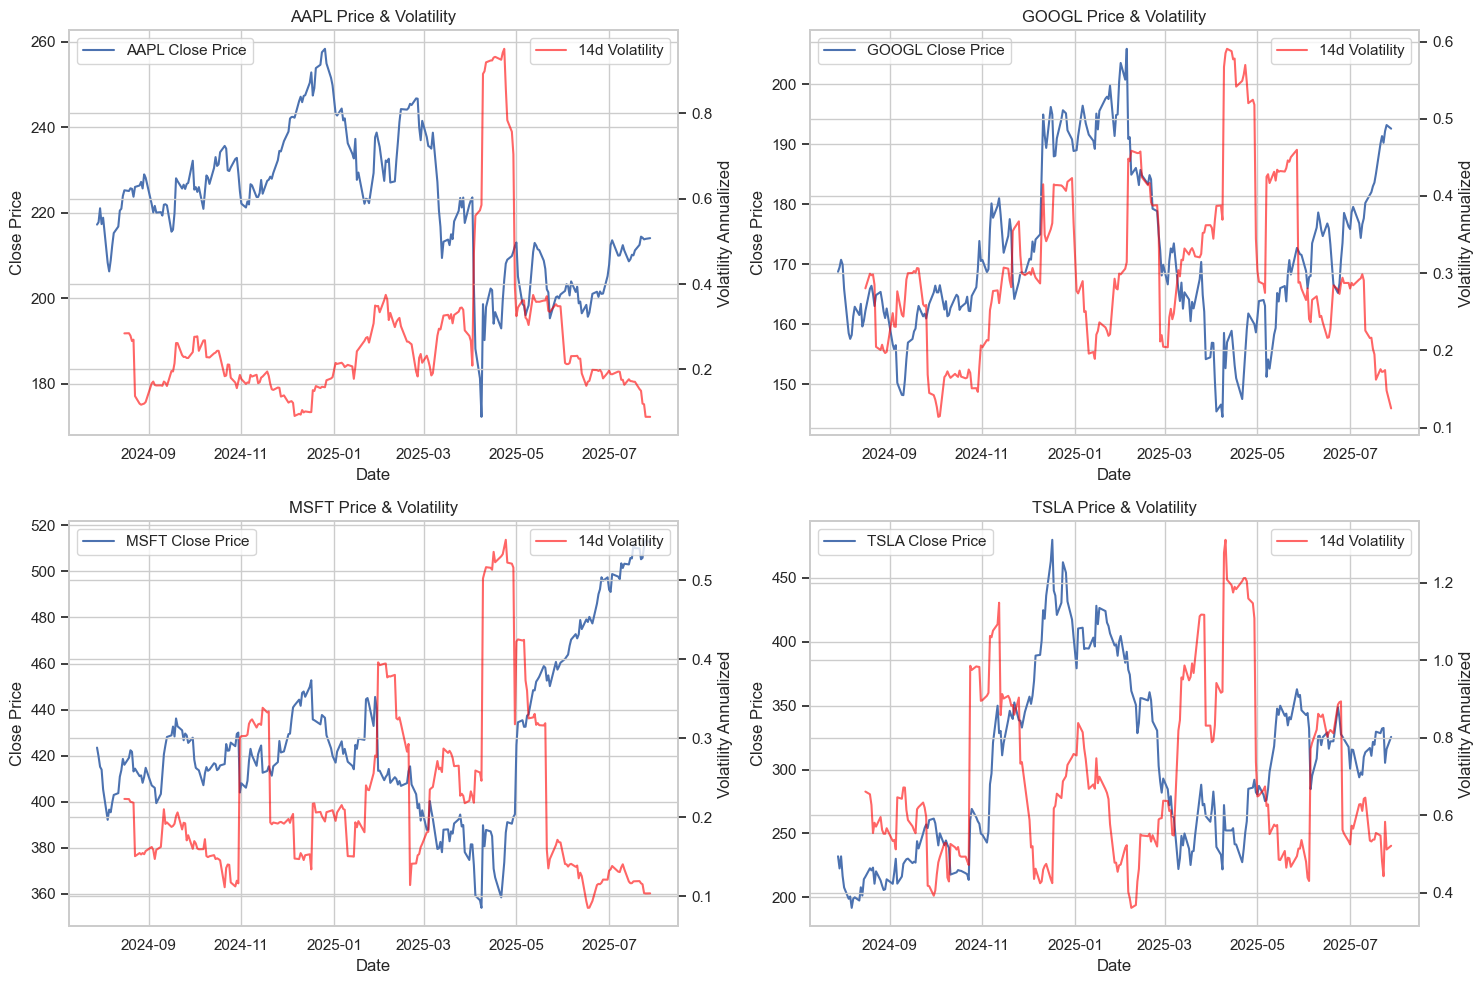

[INFO] EDA completed


Return and Volatility Summary:

 AAPL:
 Mean Daily Return: -0.0001 (-0.01% annualized)
 Return std dev: 0.0198
 Average Volatility: 0.27%

 GOOGL:
 Mean Daily Return: 0.0005 (0.13% annualized)
 Return std dev: 0.0197
 Average Volatility: 0.30%

 MSFT:
 Mean Daily Return: 0.0008 (0.19% annualized)
 Return std dev: 0.0155
 Average Volatility: 0.23%

 TSLA:
 Mean Daily Return: 0.0014 (0.34% annualized)
 Return std dev: 0.0453
 Average Volatility: 0.69%


In [8]:
logger.info('Starting exploratory data analysis')

fig, axes = plt.subplots(2,2, figsize=(15,10))
axes = axes.flatten()

for i, (name, df) in enumerate(cleaned_data.items()):
    axes[i].plot(df['date'], df['close'], label=f'{name.upper()} Close Price')
    axes[i].set_title(f'{name.upper()} Price & Volatility')
    axes[i].set_xlabel('Date')
    axes[i].set_ylabel('Close Price')

    # Add volatility on secondary axis
    ax2 = axes[i].twinx()
    ax2.plot(df['date'], df['volatility_14d'], color='red', label='14d Volatility', alpha=0.6)
    ax2.set_ylabel('Volatility Annualized')

    axes[i].legend(loc='upper left')
    ax2.legend(loc='upper right')

plt.tight_layout()
plt.show()

# Summary Statistics
print('Return and Volatility Summary:')
for name, df in cleaned_data.items():
    valid_returns = df['daily_return'].dropna()
    valid_vol = df['volatility_14d'].dropna()
    print(f'\n {name.upper()}:')
    print(f' Mean Daily Return: {valid_returns.mean():.4f} ({valid_returns.mean()*252:.2f}% annualized)')
    print(f' Return std dev: {valid_returns.std():.4f}')
    print(f' Average Volatility: {valid_vol.mean():.2f}%')

logger.info('EDA completed')


## GARCH model preparation check

In [9]:
logger.info('Starting data quality assessment for GARCH modeling')

print(' Data Quality Check for GARCH Modeling:')
for name, df in cleaned_data.items():
    returns = df['daily_return'].dropna()

    print(f'\n{name.upper()}:')
    print(f' Valid return observations: {len(returns)}')
    print(f' Skewness: {skew(returns):.3f}')
    print(f' Kurtosis: {kurtosis(returns):.3f}')
    print(f' Jarque-Bera test p-value: {jarque_bera(returns)[1]:.4f}')

    abs_returns = returns.abs()
    autocorr_1 = abs_returns.autocorr(lag=1)
    print(f' Volatility clustering (lag-1 autocorr of |returns|): {autocorr_1:.3f}')

logger.info('Data quality assessment completed')

[INFO] Starting data quality assessment for GARCH modeling
[INFO] Data quality assessment completed


 Data Quality Check for GARCH Modeling:

AAPL:
 Valid return observations: 249
 Skewness: 0.576
 Kurtosis: 12.893
 Jarque-Bera test p-value: 0.0000
 Volatility clustering (lag-1 autocorr of |returns|): 0.347

GOOGL:
 Valid return observations: 249
 Skewness: -0.217
 Kurtosis: 2.934
 Jarque-Bera test p-value: 0.0000
 Volatility clustering (lag-1 autocorr of |returns|): 0.069

MSFT:
 Valid return observations: 249
 Skewness: 0.638
 Kurtosis: 8.688
 Jarque-Bera test p-value: 0.0000
 Volatility clustering (lag-1 autocorr of |returns|): -0.006

TSLA:
 Valid return observations: 249
 Skewness: 0.385
 Kurtosis: 3.223
 Jarque-Bera test p-value: 0.0000
 Volatility clustering (lag-1 autocorr of |returns|): 0.056


## GARCH modeling setup

In [10]:
logger.info('Setting up GARCH modeling environment')

try:
    from arch import arch_model
    logger.info('ARCH library already available')
except ImportError:
    logger.info('Installing ARCH library')
    import subprocess
    subprocess.check_call(['pip', 'install', 'arch'])
    from arch import arch_model

logger.info('GARCH modeling setup completed')

[INFO] Setting up GARCH modeling environment
[INFO] ARCH library already available
[INFO] GARCH modeling setup completed


## Fit GARCH(1,1) models

In [11]:
logger.info('Fitting GARCH(1,1) models')

garch_results = {}

for name, df in cleaned_data.items():
    logger.info(f'Fitting GARCH model for: {name.upper()}')
    returns = df['daily_return'].dropna() * 100

    model = arch_model(returns, vol='Garch', p=1, q=1, dist='normal')
    fitted_model = model.fit(disp='off')

    garch_results[name] = {
        'model': fitted_model,
        'returns': returns,
        'conditional_volatility': fitted_model.conditional_volatility
    }

    print(f'\n{name.upper()} GARCH(1,1) Model Summary:')
    print(f' AIC: {fitted_model.aic:.2f}')
    print(f' Log-likelihood: {fitted_model.loglikelihood:.2f}')
    print(f' Alpha (ARCH effect): {fitted_model.params["alpha[1]"]:.4f}')
    print(f' Beta (GARCH effect): {fitted_model.params["beta[1]"]:.4f}')
    print(f' Persistence (Alpha + Beta): {fitted_model.params["alpha[1]"] + fitted_model.params["beta[1]"]:.4f}')

print('GARCH model fitting complete')


[INFO] Fitting GARCH(1,1) models
[INFO] Fitting GARCH model for: AAPL
[INFO] Fitting GARCH model for: GOOGL
[INFO] Fitting GARCH model for: MSFT
[INFO] Fitting GARCH model for: TSLA



AAPL GARCH(1,1) Model Summary:
 AIC: 976.37
 Log-likelihood: -484.18
 Alpha (ARCH effect): 0.1205
 Beta (GARCH effect): 0.8621
 Persistence (Alpha + Beta): 0.9826

GOOGL GARCH(1,1) Model Summary:
 AIC: 1045.94
 Log-likelihood: -518.97
 Alpha (ARCH effect): 0.0396
 Beta (GARCH effect): 0.9291
 Persistence (Alpha + Beta): 0.9688

MSFT GARCH(1,1) Model Summary:
 AIC: 919.53
 Log-likelihood: -455.76
 Alpha (ARCH effect): 0.0833
 Beta (GARCH effect): 0.8513
 Persistence (Alpha + Beta): 0.9346

TSLA GARCH(1,1) Model Summary:
 AIC: 1464.23
 Log-likelihood: -728.12
 Alpha (ARCH effect): 0.0000
 Beta (GARCH effect): 0.9859
 Persistence (Alpha + Beta): 0.9859
GARCH model fitting complete


## Model performance comparison

In [12]:
logger.info('Comparing GARCH model performance')

comparison_data = []
for name, result in garch_results.items():
    model = result['model']
    comparison_data.append({
        'Stock': name.upper(),
        'AIC': model.aic,
        'Log-Likelihood': model.loglikelihood,
        'Alpha': model.params['alpha[1]'],
        'Beta': model.params['beta[1]'],
        'Persistence': model.params['alpha[1]'] + model.params['beta[1]']
    })

comparison_df = pd.DataFrame(comparison_data)
comparison_df = comparison_df.sort_values('AIC')
print('GARCH(1,1) Model Comparison (sorted by AIC - lower is better):')
display(comparison_df.round(4))

logger.info('GARCH model performance comparison completed')



[INFO] Comparing GARCH model performance


GARCH(1,1) Model Comparison (sorted by AIC - lower is better):


,Stock,AIC,Log-Likelihood,Alpha,Beta,Persistence
2,MSFT,919.5273,-455.7637,0.0833,0.8513,0.9346
0,AAPL,976.3688,-484.1844,0.1205,0.8621,0.9826
1,GOOGL,1045.9387,-518.9693,0.0396,0.9291,0.9688
3,TSLA,1464.2340,-728.1170,0.0000,0.9859,0.9859


[INFO] GARCH model performance comparison completed
